## Baseline Classifier

In [1]:
%pwd
%cd d:\\Murgi\\code\\memes2024\\meme-research-2024
%pwd


d:\Murgi\code\memes2024\meme-research-2024


d:\Murgi\code\memes2024\meme-research-2024\phash\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'd:\\Murgi\\code\\memes2024\\meme-research-2024'

Import libs

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from skimage import feature
from PIL import Image
from joblib import Parallel, delayed
import multiprocessing
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, f1_score
import mlflow
import constants
import os


### Load data

In [21]:
meme_df = pd.read_parquet("./data\meme_entries.parquet")
meme_df

,id,template_name,path,phash
0,0-days-without-lenny-simpsons,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,0fe9b236e884fc38
1,0-days-without-Lenny-Simpsons_23,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,07e5ba2ee806fe30
2,0-days-without-Lenny-Simpsons_1,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,1fed3226e804fe38
3,0-days-without-Lenny-Simpsons_24,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,07e1b83ee886fa38
4,0-days-without-Lenny-Simpsons_10,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,17e5b22ee806fe30
...,...,...,...,...
124196,skeleton-computer-84,skeleton-computer,D:/Memes2024/Skeleton-Computer/skeleton-comput...,e1e68b1929253d3d
124197,nick-young-178,nick-young,D:/Memes2024/Nick-Young/nick-young-178.jpg,4bd5913e14da4e55
124198,success-kid-original-196,success-kid-original,D:/Memes2024/Success-Kid-Original/success-kid-...,1d1d301f32c3f2e3
124199,Wrong-Neighboorhood-Cats_23,wrong-neighboorhood-cats,D:/Memes2024/Wrong-Neighboorhood-Cats/Wrong-Ne...,a950535053abb3bb


### EDA - exploring the data

Color Histogram

D:/Memes2024/0-days-without-Lenny-Simpsons/0-days-without-lenny-simpsons.png


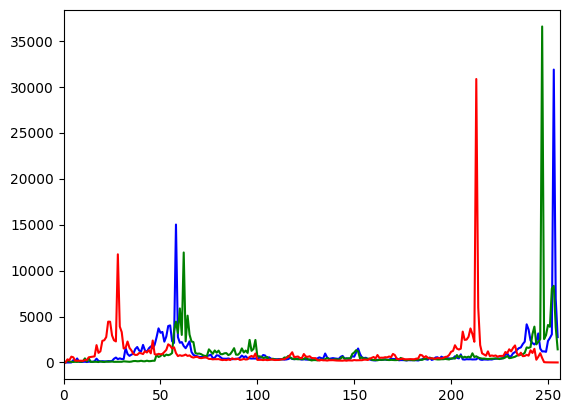

In [22]:

path = meme_df.path.iloc[0]
print(path)
img = cv2.imread(path)
color = ('b','g','r')
for i, col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


HSV Histogram

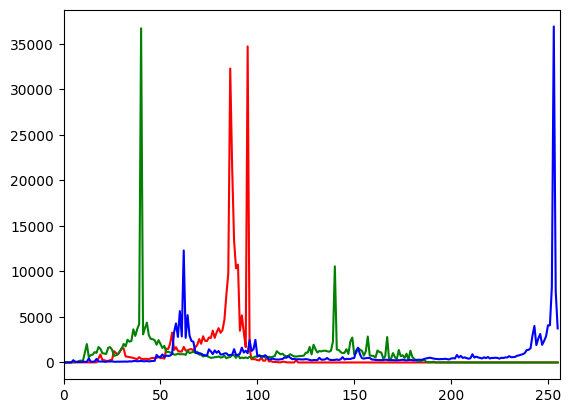

In [23]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
color = ('r','g','b') # Changed to RGB
for i, col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


Grayscale Histograms:

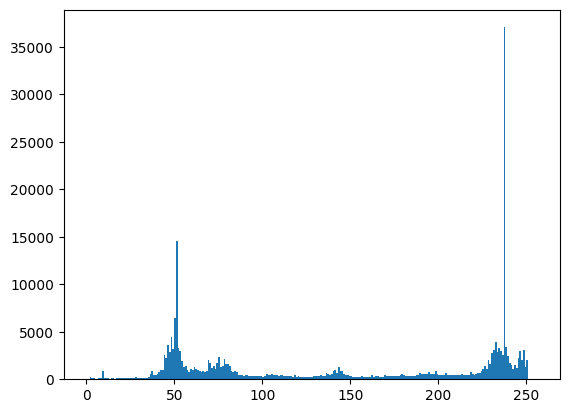

In [24]:
img = cv2.imread(path,0)
plt.hist(img.ravel(),256,[0,256])
plt.show()


Texture Features:

<BarContainer object of 28 artists>

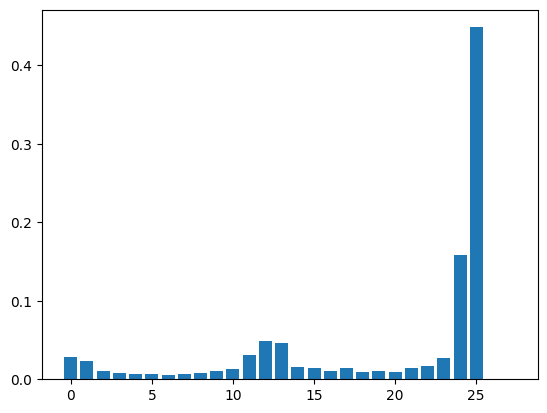

In [25]:

# Convert the image to grayscale if it is in color
if len(img.shape) == 3:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    gray = img

# Compute LBP features
lbp = feature.local_binary_pattern(gray, P=24, R=8, method="uniform")

# Calculate the histogram
n_points = lbp.max() + 1
lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

# Normalize the histogram
lbp_hist = lbp_hist.astype("float")
lbp_hist /= (lbp_hist.sum() + 1e-7)

# Display the LBP features
plt.bar(x=np.arange(0, n_points + 2), height=lbp_hist)

### Combine these into a pipeline

In [26]:


def extract_features(image_path):
    # Check if the file is a GIF
    if image_path.endswith('.gif') or image_path.endswith('.GIF'):
        img = Image.open(image_path)
        img = img.convert('RGB') # Convert to RGB
        img = np.array(img) # Convert to NumPy array
    else:
        img = cv2.imread(image_path)
        if img is None or img.size == 0:
            print(f"Failed to load image at path {image_path}")
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to standard RGB

    # convert image to HSV and calculate HSV histogram
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_features = []
    for i in range(3):  # for each channel
        hist = cv2.calcHist([hsv_img], [i], None, [256], [0, 256])
        hsv_features.extend(hist.flatten())

    # convert image to grayscale and calculate grayscale histogram
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grayscale_hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    grayscale_features = grayscale_hist.flatten()

    # calculate LBP features
    lbp = feature.local_binary_pattern(gray, P=24, R=8, method="uniform")
    n_points = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_features = lbp_hist.astype("float")
    lbp_features /= (lbp_features.sum() + 1e-7)  # normalize histogram

    # Check the length of the LBP features and append a zero if necessary, to have a consistent length of features in all images
    if len(lbp_features) == 27:
        lbp_features = np.append(lbp_features, 0)

    # concatenate all features into a single feature vector
    feature_vector = np.hstack([hsv_features, grayscale_features, lbp_features])

    # Debug only:
    # print("HSV features shape:", len(hsv_features))
    # print("Grayscale features shape:", len(grayscale_features))
    # print("LBP features shape:", len(lbp_features))

    return feature_vector

# example usage:
# image_path = 'meme.jpg'
# features = extract_features(image_path)

### Preprocessing

In [27]:
image_paths = meme_df['path'].tolist()
len(image_paths)

124201

Extract features from the dataset

In [32]:
from tqdm.contrib.concurrent import thread_map  # or thread_map

# Get number of cores
num_cores = multiprocessing.cpu_count() - 1

# test_image_paths = image_paths[:1]

# Use joblib to parallelize feature extraction
start = time.time()
features = thread_map(extract_features, image_paths, max_workers=num_cores)
end = time.time()
print(f"Time taken to extract features from {len(image_paths)} images: {end-start:.2f} seconds")


  0%|          | 0/124201 [00:00<?, ?it/s]

Time taken to extract features from 124201 images: 2573.96 seconds


In [33]:
features = np.array(features)
features.shape

(124201, 1052)

In [34]:
# Save features as a numpy array
np.save('baseline_features.npy', features)

In [35]:
features = np.load('baseline_features.npy')

In [40]:
features.shape

(124201, 1052)

In [41]:
X = features
X = X.astype('float32')

labelencoder = LabelEncoder()
meme_df['template_id'] = labelencoder.fit_transform(meme_df['template_name'])

y = meme_df['template_id'].copy()


### Train a classifier

In [37]:
mlflow.set_tracking_uri('https://dagshub.com/levente-murgas/meme-research-2024.mlflow')
# # Recommended to define as environment variables
os.environ['MLFLOW_TRACKING_USERNAME'] = constants.MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = constants.MLFLOW_TRACKING_PASSWORD

In [38]:
def get_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
      exp_id = mlflow.create_experiment(name)
      return exp_id
    return exp.experiment_id


exp_id = get_experiment_id(f"mlr_cross_val")
print(exp_id)

9


In [44]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

mcc_scores = []
kappa_scores = []
f1_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf= LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='lbfgs', random_state=42, n_jobs=-1)
    
    with mlflow.start_run(experiment_id=exp_id):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mcc = matthews_corrcoef(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        f1 =  f1_score(y_test, y_pred, average='weighted')
        mcc_scores.append(mcc)
        kappa_scores.append(kappa)
        f1_scores.append(f1)
        mlflow.log_metric('matthews_corrcoef', mcc)
        mlflow.log_metric('cohen_kappa_score', kappa)
        mlflow.log_metric('f1_score', f1)
        mlflow.sklearn.log_model(clf, 'mlr_model', registered_model_name='mlr_model')

with mlflow.start_run(experiment_id=exp_id):
    mlflow.log_metric('mean_mcc', np.mean(mcc_scores))
    mlflow.log_metric('mean_kappa', np.mean(kappa_scores))
    mlflow.log_metric('mean_f1', np.mean(f1_scores))
    mlflow.set_tag('cross val results', 'MultinomialLogisticRegression')

Successfully registered model 'mlr_model'.
2024/04/23 15:01:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mlr_model, version 1
Created version '1' of model 'mlr_model'.
Registered model 'mlr_model' already exists. Creating a new version of this model...
2024/04/23 15:33:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mlr_model, version 2
Created version '2' of model 'mlr_model'.
Registered model 'mlr_model' already exists. Creating a new version of this model...
2024/04/23 16:02:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mlr_model, version 3
Created version '3' of model 'mlr_model'.
Registered model 'mlr_model' already exists. Creating a new version of this model...
2024/04/23 16:32:44 INFO mlflow.store.model_registry.abstract_store: Waiting u

-----

Define hyperparameters

In [ ]:
crange = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]
hyperparam_grid = { "solver": ["newton-cg", "lbfgs", "sag", "saga"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]}

Hyperparameter tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Initialize and train the logistic regression model

# Define evaluation procedure with GridSearchCV
grid = GridSearchCV(clf, hyperparam_grid, cv=5, scoring='f1_weighted', n_jobs=-3, verbose=2)

# Train the model
grid.fit(X_train, y_train)

print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

# Get the best model
clf = grid.best_estimator_

In [17]:
# Compute MCC, Kappa, and F1 Score on the test set
clf= LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='lbfgs', random_state=42)

clf.fit(X_train, y_train)

c:\Users\Murgi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=42)

In [19]:
# Split a numpy array to chunks
def split_arr_to_chunks(array, chunk_size):
    return np.split(array, np.arange(chunk_size, len(array), chunk_size))

def split_df_to_chunks(df, chunk_size):
    num_rows = len(df)
    num_batches = (num_rows + chunk_size - 1) // chunk_size
    
    # Create a list of DataFrames, each with batch_size number of rows
    batches = [df[i*chunk_size:(i+1)*chunk_size] for i in range(num_batches)]
    
    return batches

In [20]:
# Initialize variables to keep track of predictions and true labels
y_test_all = np.array([])
y_predicted_all = np.array([])

# Evaluate on the test set in chunks
X_test_chunks = split_arr_to_chunks(X_test, 500)
y_test_chunks = split_df_to_chunks(y_test, 500)

for X_test_chunk, y_test_chunk in tqdm(zip(X_test_chunks, y_test_chunks), total=len(X_test_chunks), desc="Evaluating the model on the test set"):
    y_predicted = clf.predict(X_test_chunk)
    y_test_all = np.concatenate([y_test_all, y_test_chunk])
    y_predicted_all = np.concatenate([y_predicted_all, y_predicted])


# Compute Matthews correlation coefficient
mcc = matthews_corrcoef(y_test_all, y_predicted_all)

# Compute Cohen's Kappa
kappa = cohen_kappa_score(y_test_all, y_predicted_all)

# Compute F1 Score
f1 = f1_score(y_test_all, y_predicted_all, average='weighted')

scores = {'matthews_corrcoef': mcc, 'cohen_kappa': kappa, 'f1_score': f1}
print(scores)

Evaluating the model on the test set: 100%|██████████| 616/616 [02:00<00:00,  5.10it/s]


{'matthews_corrcoef': 0.09025981594760468, 'cohen_kappa': 0.09023841094751872, 'f1_score': 0.07527276798215861}


In [23]:
import json

with open("C:/Users/Murgi/Documents/GitHub/meme_research/outputs/metrics/baseline_scores.json", "w") as f:
    json.dump(scores, f)